In [ ]:
#imports
import pandas as pd                                                                                                
import numpy as np

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import classifier
import plots
import preprocess

In [2]:
# loading the data into Pandas dataframes
t_data = pd.read_csv('training_data_example.csv')
v_data = pd.read_csv('validation_data_example.csv')
e_data = pd.read_csv('employee.csv', index_col='employee id')

# Feature Extraction

The dataset provides the following features:
-  Employee ID (Categorical): Using this ID, further information about the employee can be extracted from auxiliary dataset (employee.csv) such as Employee name, Employee address, role. Among these further details, I only used role (Categorical) as a feature. Because, Employee name is redudant when Employee ID is given. Though Employee address could have played a role, I didn't include this feature because I guess it is redundant with 'Tax name' feature, for example, employee id 7 who is based in New York has all expenses with NY Sales tax. And I think including a specific part of address like Street name will act like noise.
-  Expense Description (Text): This I believe is the most important feature that's available. By looking at the description one can almost say which category it belongs to. In fact when I tested with only description as a feature I got similar (slightly better) performance compared to the performance in combination of all other features. However, in practise people won't always write good descriptions (or may write too specific decription), that's why it is better to use other features that are available. Converting text into numerical features can be done in lot of ways, starting with simple Bag of Words, I experimented with three different ways to represent the expense description:
    -  Term Frequency-Inverse Document frequency (tf-idf): Term Frequency cares about the number of times a word appears in a particular description, Inverse Document Frequency gives less importance to words which are in every description. However, the descriptions in this dataset are very precise therefore I don't think there is any advantage of using (tf-idf) over simple term frequency count. And the vocabulary is built based on the descriptions in the provided dataset, with a cutoff frequency to ignore very specific words (like 'steve' in 'coffee with steve').
    -  Word Embeddings (combined using mean): Based on my experience with very small datasets like these, transfer learning approaches work very well. I used GloVe (https://nlp.stanford.edu/projects/glove/), where each word in description is represented by a 50 dimensional vector and combined by taking a mean of those vectors.
    -  Word Embeddings (Combined using weighted mean): Here the embeddings of each word are combined using weighted mean, where the weights are calculated using the tf-idf of each word. 
-  Pre-Tax amount (Continous value): Taken as it is.
-  Tax amount (Continous value): Taken as it is.
-  Tax Name (Categorical): Encoded using LabelEncoder

In [3]:
# Obtain the processed features (excluding expense description) for training and validation datasets
(Xtrain, Xval) = preprocess.data_matrix(t_data, v_data, e_data)

# Simple tf-idf encoding of the text, small min_df means smaller vocabulary size,
# consequently lesser dimension of features
sklearn_tfidf = preprocess.TfidfVectorizer(min_df=0.05,sublinear_tf=True, dtype=np.int8)
sklearn_tfidf.fit(t_data['expense description'])
exp_sklearn = sklearn_tfidf.transform(t_data['expense description'])
val_exp_sklearn = sklearn_tfidf.transform(v_data['expense description'])

# combine the remaining features with the'description' feature
Xtrain_sklearn = np.c_[exp_sklearn.toarray(), Xtrain]
Xval_sklearn = np.c_[val_exp_sklearn.toarray(), Xval]

Before running next two cells, you have to download the embeddings and keep in same folder as this file. 
-  > wget http://nlp.stanford.edu/data/glove.6B.zip
-  > unzip glove.6B.zip

In [4]:
with open("glove.6B.50d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}
embed_mean = preprocess.MeanEmbeddingVectorizer(w2v)
embed_mean.fit(t_data['expense description'])
exp_embed_mean = embed_mean.transform(t_data['expense description'])
val_exp_embed_mean = embed_mean.transform(v_data['expense description'])

# combine the remaining features with the'description' feature
Xtrain_embed_mean = np.c_[exp_embed_mean, Xtrain]
Xval_embed_mean = np.c_[val_exp_embed_mean, Xval]

In [5]:
embed_tfidf = preprocess.TfidfEmbeddingVectorizer(w2v)
embed_tfidf.fit(t_data['expense description'])
exp_embed_tfidf = embed_tfidf.transform(t_data['expense description'])
val_exp_embed_tfidf = embed_tfidf.transform(v_data['expense description'])

# combine the remaining features with the'description' feature
Xtrain_embed_tfidf = np.c_[exp_embed_tfidf, Xtrain]
Xval_embed_tfidf = np.c_[val_exp_embed_tfidf, Xval]

In [6]:
# Converting the category column using LabelEncoder
ce = preprocessing.LabelEncoder()
ce.fit(t_data['category'])
ytrain = ce.transform(t_data['category'])
yval = ce.transform(v_data['category'])

# Model Selection

By observing the dataset one can see that if-else sort of conditions can be easily applied for the classification. If the description has "Taxi" then it is 'Travel' expense, if the employer is 'IT Admin', his purchases could be 'Computer Software' or 'Computer Hardware'. And in my experience/ knowledge, decision trees work best for this type of data as essentially each decision stump is an 'if-else' condition. And by using an ensemble of trees or Gradient Boosting (where each new tree is constructed to fix the misclassifications of previous tree) the over-fitting problem of simple decision tree can be countered. So I used the following models for classification:
-  XGBoostClassifier: This is a very popular Gradient Boosting package, and I think this is the de-facto model for lot of Kaggle competitions. There are many parameters to be tuned with xgboost, controlling the depth of each tree, regularization on weights etc, hence I used grid search on some of these parameters to find out the best ones over training set. Also this document helped me in parameter tuning (https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).
-  ExtraTreesClassifier: This is an ensemble of a number of randomized decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. Fortunately, this doesn't have many hyperparameters to tune compared to xgboost. On this particular dataset ExtraTreesClassifier works better than xgboost, but with past experience with xgboost is that it generalizes better than ensemble of trees.

# Hyper parameter tuning
Owing to very small size of training dataset, it doesn't make sense to do train_test_split, k-fold cross validations, therefore I opted leave one out cross validation for grid search of hyperparameters as described below

In [7]:
clf0 = classifier.Classifier('xgboost', objective='multi:softmax')
loo = LeaveOneOut()
tuned_parameters = {'min_child_weight':[1,2,4],'max_depth':[3,5,7],'subsample':[0.5,0.7],
                    'colsample_bytree':[0.5,0.7],'reg_alpha':[0,1,3]}
clf1 = GridSearchCV(clf0.model, tuned_parameters, cv=loo, scoring='accuracy')
clf1.fit(Xtrain_sklearn, ytrain)
print(clf1.best_params_)

{'subsample': 0.5, 'reg_alpha': 3, 'colsample_bytree': 0.5, 'max_depth': 3, 'min_child_weight': 1}


In [8]:
clf0 = classifier.Classifier('trees')
tuned_parameters = {'n_estimators':[10,20,30,50],'min_samples_leaf':[1,2,3,5]}
clf1 = GridSearchCV(clf0.model, tuned_parameters, cv=loo, scoring='accuracy')
clf1.fit(Xtrain_sklearn, ytrain)
print(clf1.best_params_)

{'n_estimators': 50, 'min_samples_leaf': 1}


# Comparison of different text representations

Here I compare the performance using different representaions of 'expense description' text feature as explained earlier. I guess because the descriptions are so simple, all 3 representations give same performance though embeddings (when combined with mean) have slight edge.

In [9]:
loo = LeaveOneOut()
clf = classifier.Classifier('trees',n_estimators=50,min_samples_leaf=1)
scores = cross_val_score(clf.model, Xtrain_embed_mean, ytrain,cv=loo)
print("Accuracy with embeddings (mean combination): %0.2f" % (scores.mean()))

clf = classifier.Classifier('trees',n_estimators=50,min_samples_leaf=1)
scores = cross_val_score(clf.model, Xtrain_embed_tfidf, ytrain,cv=loo)
print("Accuracy with embeddings (weighted mean combination): %0.2f" % (scores.mean()))

clf = classifier.Classifier('trees',n_estimators=50,min_samples_leaf=1)
scores = cross_val_score(clf.model, Xtrain_sklearn, ytrain,cv=loo)
print("Accuracy with tf-idf representation: %0.2f" % (scores.mean()))

Accuracy with embeddings (mean combination): 0.79
Accuracy with embeddings (weighted mean combination): 0.75
Accuracy with tf-idf representation: 0.71


# Performance
To evaluate the models for classification, it is often important to look at precision, recall (or f1-score which includes both of these) along with accuracy. Because for validation dataset even if one reports everything as 'meals and entertainment' one could still get ~60% accuracy but the precision is going to be very low. Confusion matrix gives a clear picture of mis-classifications between classes. 

Though I reported accuracy, classification report on Training and Validation sets, reports on Training set shouldn't be taken seriously, as the model was trained on same set. Infact the cross validation results of previous cell  along with Validation results are good indicators of performance.


!!!Training Set Results!!!
Accuracy with XGBoost: 1.0
                         precision    recall  f1-score   support

    Computer - Hardware       1.00      1.00      1.00         3
    Computer - Software       1.00      1.00      1.00         4
Meals and Entertainment       1.00      1.00      1.00        10
        Office Supplies       1.00      1.00      1.00         1
                 Travel       1.00      1.00      1.00         6

            avg / total       1.00      1.00      1.00        24

Confusion matrix, without normalization


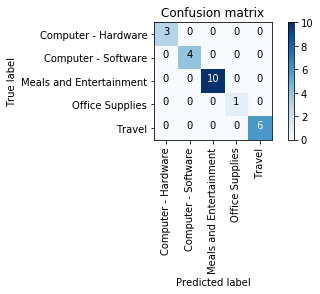

!!!Validation Set Results!!!
Accuracy with XGBoost: 0.916666666667
                         precision    recall  f1-score   support

    Computer - Hardware       1.00      1.00      1.00         1
    Computer - Software       0.00      0.00      0.00         0
Meals and Entertainment       0.88      1.00      0.93         7
        Office Supplies       1.00      0.50      0.67         2
                 Travel       1.00      1.00      1.00         2

            avg / total       0.93      0.92      0.91        12

Confusion matrix, without normalization


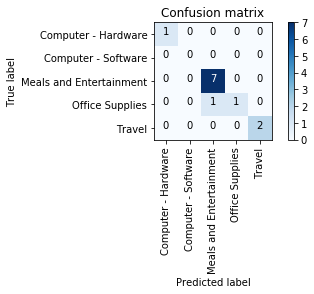

In [10]:
clf = classifier.Classifier('xgboost',reg_alpha=0,colsample_bytree=0.5,min_child_weight=1,subsample=0.5,
                            max_depth=3)
clf.train(Xtrain_embed_mean, ytrain)
ypred = clf.predict(Xtrain_embed_mean)
print "!!!Training Set Results!!!"
print "Accuracy with XGBoost: {}".format(accuracy_score(ytrain, ypred))
print classification_report(ytrain, ypred, target_names=ce.classes_)
cm = confusion_matrix(ytrain, ypred)
plots.plot_confusion_matrix(cm, classes=ce.classes_)

ypred = clf.predict(Xval_embed_mean)
print "!!!Validation Set Results!!!"
print "Accuracy with XGBoost: {}".format(accuracy_score(yval, ypred))
print classification_report(yval, ypred, labels=np.arange(len(ce.classes_)), target_names=ce.classes_)
cm = confusion_matrix(yval, ypred, labels=np.arange(len(ce.classes_)))
plots.plot_confusion_matrix(cm, classes=ce.classes_)

!!!Training Set Results!!!
Accuracy with Ensemble of Trees: 1.0
                         precision    recall  f1-score   support

    Computer - Hardware       1.00      1.00      1.00         3
    Computer - Software       1.00      1.00      1.00         4
Meals and Entertainment       1.00      1.00      1.00        10
        Office Supplies       1.00      1.00      1.00         1
                 Travel       1.00      1.00      1.00         6

            avg / total       1.00      1.00      1.00        24

Confusion matrix, without normalization


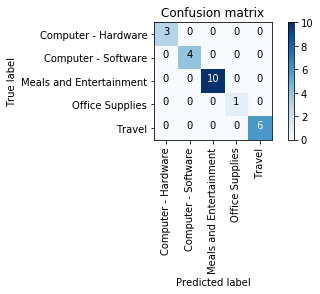

!!!Validation Set Results!!!
Accuracy with Ensemble of Trees: 0.916666666667
                         precision    recall  f1-score   support

    Computer - Hardware       1.00      1.00      1.00         1
    Computer - Software       0.00      0.00      0.00         0
Meals and Entertainment       0.88      1.00      0.93         7
        Office Supplies       1.00      0.50      0.67         2
                 Travel       1.00      1.00      1.00         2

            avg / total       0.93      0.92      0.91        12

Confusion matrix, without normalization


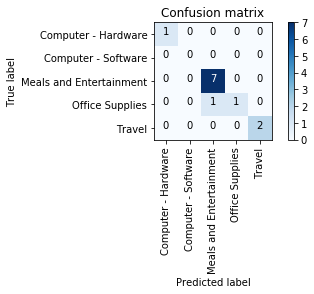

In [11]:
clf = classifier.Classifier('trees',n_estimators=50,min_samples_leaf=1)
clf.train(Xtrain_embed_mean, ytrain)
ypred = clf.predict(Xtrain_embed_mean)
print "!!!Training Set Results!!!"
print "Accuracy with Ensemble of Trees: {}".format(accuracy_score(ytrain, ypred))
print classification_report(ytrain, ypred, target_names=ce.classes_)
cm = confusion_matrix(ytrain, ypred)
plots.plot_confusion_matrix(cm, classes=ce.classes_)

ypred = clf.predict(Xval_embed_mean)
print "!!!Validation Set Results!!!"
print "Accuracy with Ensemble of Trees: {}".format(accuracy_score(yval, ypred))
print classification_report(yval, ypred, labels=np.arange(len(ce.classes_)), target_names=ce.classes_)
cm = confusion_matrix(yval, ypred, labels=np.arange(len(ce.classes_)))
plots.plot_confusion_matrix(cm, classes=ce.classes_)